<p style="font-size:25px;">**Before using this notebook:**

1. Gather FASTQ files for each round of selection
2. Use APTASUITE to convert raw FASTQ files into tab delimited files containing the Aptamer_Id, Sequence, and number of reads from each round of selection

<p style="font-size:25px;">Load required packages and import data into Counts

Counts is a dictionary with key = sequence, value = {'ID': list, 'Round0':integer, 'Round1':integer, etc}

In [1]:
import numpy as np
import nltk
from Bio import Align
from Bio.Seq import Seq
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import itertools
import time
import pandas as pd
import warnings


In [2]:
def import_data(Counts, path1, round_list):
    file = open(path1, "r")
    content = file.readlines()
    for i in content[1:]:
        line = i.strip('\n').split('\t')
        ID = line[0]
        sequence = line[1]
        if sequence not in Counts:
            Counts[sequence] = {'ID': [ID]}
            line_num = 2
            for Rn in round_list:
                Counts[sequence]['R' + Rn] = int(line[line_num])
                line_num += 1
        elif sequence in Counts and 'R' + round_list[0] in Counts[sequence]:
            Counts[sequence]['ID'].append(ID)
            line_num = 2
            for Rn in round_list:
                Counts[sequence]['R' + Rn] += int(line[line_num])
                line_num += 1
        elif sequence in Counts and 'R' + round_list[0] not in Counts[sequence]:
            Counts[sequence]['ID'].append(ID)
            line_num = 2
            for Rn in round_list:
                Counts[sequence]['R' + Rn] = int(line[line_num])
                line_num += 1
    file.close()
    return(Counts)


In [3]:
# Import data from each APTASUITE tab delimited file
# Counts = dictionary with key = sequence, value = {'ID': [], 'Round_number':integer}

Counts = {}

path1 = r'D:/093025 NASA backup/In vitro selection of 2 RNAs/090424 - 010325 emulsion selection/092424 sequence data/PairedEndV2/export/pool.txt'
path1_round_list = ['0', '5', '6'] # Each entry in the list is a string
Counts = import_data(Counts, path1, path1_round_list)

path2 = r'D:/093025 NASA backup/iSeqA/2024/20241031_FS10000323_105_BTR99609-1932/Alignment_2/20241104_093040/Fastq/110424analysisV3/export/pool.txt'
path2_round_list = ['8', '8_expected_size', '9', '9_expected_size', '9_small_size'] # Each entry in the list is a string
Counts = import_data(Counts, path2, path2_round_list)

# For any sequences that appear only in the second file, 0 for their counts in the rounds from the first file
all_rounds = path1_round_list + path2_round_list
for s in Counts:
    for r in all_rounds:
        index = 'R' + r
        if index not in Counts[s]:
            Counts[s][index] = 0


<p style="font-size:25px;"> Do kmeans clustering on the expected length sequences that have more reads in Round9 than the read_threshold
<p style="font-size:12px;"> First, set parameter values:
<p style="font-size:12px;"> read_threshold = each variant must have more reads in the given round than the read threshold to be considered in this calculation


In [4]:
read_threshold = 1

In [5]:
def find_RNA(DNA1, constant_region):
    # Find RNA in the sense direction by identifying T7 promoter sequence. 
    # Everything after the promoter (including the final GG of the promoter) is part of the RNA.
    # Then append the appropriate constant region (which is cut out during processing by aptasuite)
    T7_promoter = Seq('TAATACGACTCACTATAGG')
    min_distance = 4
    RNA = None
    for i in range(len(DNA1) - len(T7_promoter)):
        substring = DNA1[i:i + len(T7_promoter)]
        edit_dist = nltk.edit_distance(substring, T7_promoter)
        if edit_dist <= min_distance:
            min_distance = edit_dist
            gene = DNA1[i + 17:]  + constant_region
            RNA = gene.transcribe()
    return(RNA)

def find_all_RNAs(DNA1):
    sense_constant_region = Seq('GTTCGTGACTAGCCTGTCGA')
    RNA1 = find_RNA(DNA1, sense_constant_region)
    DNA_rev_comp = DNA1.reverse_complement()
    antisense_constant_region = Seq('CGTCAGAGTTCCGTGAGTTG')
    RNA2 = find_RNA(DNA_rev_comp, antisense_constant_region)
    RNA_list = [x for x in [RNA1, RNA2] if x is not None]
    return(RNA_list)

def is_this_window_complementary_to_RNA_WITH_WOBBLE(window1, RNA1):
    # window1 = biopython_sequence object containing 5' to 3' sequence for a window around the ligation site for the substrates
    # RNA1 = biopython_sequence object containing 5' to 3' sequence for one of the encoded RNAs
    # Find minimum levenshtein distance between window and any substring in the reverse complement RNA 
    min_distance = 100
    min_substring_index = 0
    rev_comp_RNA = RNA1.reverse_complement().transcribe()
    l = len(window1)
    for i in range(len(rev_comp_RNA)):
        substring = rev_comp_RNA[i:i + l]
        edit_dist = nltk.edit_distance(substring, window1)
        for q in range(len(substring)):
            if substring[q] == Seq('C'):                
                substring_wobbleL = list(substring)
                substring_wobbleL[q] = 'U'
                substring_wobble = Seq(''.join(substring_wobbleL))
                edit_dist_wobble = nltk.edit_distance(substring_wobble, window1)
            elif substring[q] == Seq('A'):
                substring_wobbleL = list(substring)
                substring_wobbleL[q] == Seq('G')
                substring_wobble = Seq(''.join(substring_wobbleL))
                edit_dist_wobble = nltk.edit_distance(substring_wobble, window1)
        if edit_dist <= min_distance or edit_dist_wobble <= min_distance:
            min_distance = min(edit_dist,edit_dist_wobble)
            min_substring_index = i
    index_in_original_RNA = len(RNA1) - min_substring_index - l
    return(min_distance, index_in_original_RNA)


def check_for_complementary_RNAs_WITH_WOBBLE(RNA_list, window_list, tolerance):
    # RNA_list = list of RNAs encoded by a given DNA. Each element of the list is a biopython_sequence object containing 5' to 3' sequence for one of the encoded RNAs
    # window_list = list of windows. Each element of the list is a biopython_sequence object containing 5' to 3' sequence for a window around ligation site
    # tolerance = number of edits to tolerate
    # Check each RNA to see if it's complementary to ligation site
    distance = 100
    RNA = None
    window = 'A'
    index = None
    for RNA1 in RNA_list:
        for window1 in window_list:
            min_distance, index1 = is_this_window_complementary_to_RNA_WITH_WOBBLE(Seq(window1), RNA1)
            if min_distance <= tolerance and len(window1) >= len(window):
                distance = min_distance
                RNA = RNA1
                window = window1
                index = index1
    if distance <= tolerance:
        return([RNA, window, index])
    else:
        return(None)

def show_pairing(DNA1):
    tolerance = 1
    print('DNA sequence = ' + label_ends(str(DNA1)))
    print('R0 counts = ' + str(Counts[str(DNA1)]['R0']) + '. R5 counts = ' + str(Counts[str(DNA1)]['R5'])+ '. R6 counts = ' + str(Counts[str(DNA1)]['R6'])+'.')
    print('R8 counts = ' + str(Counts[str(DNA1)]['R8']) + '. R8_expected_size counts = ' + str(Counts[str(DNA1)]['R8_expected_size'])+'.')
    print('R9 counts = ' + str(Counts[str(DNA1)]['R9'])+'. R9_expected_size counts = ' + str(Counts[str(DNA1)]['R9_expected_size'])+'. R9_small_size counts = ' + str(Counts[str(DNA1)]['R9_small_size'])+'.')
    RNA_list = find_all_RNAs(DNA1)
    ligation_product = 'UAACAGACACUUGGUGAAGCUAGGUGGAAGCGUUGUA'
    window_list = []
    for window_length in [14,13,12,11,10,9,8,7,6,5,4]:
        window_list += ([ligation_product[x:x+window_length] for x in range(len(ligation_product)) if len(ligation_product[x:x+window_length]) == window_length])
    RNA_count = 0
    for r in RNA_list:
        RNA_count += 1
        output = check_for_complementary_RNAs_WITH_WOBBLE([r], window_list, tolerance)
        if output is not None:
            print('           RNA ' + str(RNA_count) + ' =  ' + label_ends(str(output[0])))
            print("Substrate window =  " +  " "*(output[2]) + "3'-" + str(output[1][::-1]) + "-5'")
        else:
            print(label_ends(r))
            print('None')
    print()
    print()
    
def label_ends(sequence):
    return("5'-" + sequence + "-3'")

def enrichment(dict1, R1, R2):
    if dict1[R1] > 0:
        return(dict1[R2]/dict1[R1])
    elif dict1[R1] == 0:
        return(dict1[R2]/1)
    else:
        return(0)

In [6]:
def clustering_vs_k(sequence_list1):
    n_cluster_values1 = range(2, len(sequence_list1))
    matrix = np.asarray([np.fromstring(s, dtype=np.uint8) for s in sequence_list1]) 
    sil_scores1 = []
    predictions1 = []
    tracker = 0
    tracker_output = [x for x in range(0, len(sequence_list1), int(0.25*len(sequence_list1)))]
    for n_cluster in n_cluster_values1:
        kmeans = KMeans(n_clusters=n_cluster).fit(matrix)
        label = kmeans.labels_
        sil_coeff = silhouette_score(matrix, label, metric='euclidean')
        predictions1.append(kmeans)
        sil_scores1.append(sil_coeff)
        tracker += 1
        if tracker in tracker_output:
            print(str(int(100*tracker/len(sequence_list1))) + '% of all sequences have been analyzed')
    return(n_cluster_values1, predictions1, sil_scores1)

def find_best_clustering(sequence_list1):
    # Cluster this list of sequences for different values of num_clusters
    n_cluster_values, predictions, sil_scores = clustering_vs_k(sequence_list1)
    fig, ax = plt.subplots(1, 1, figsize = (7,7))
    ax.scatter(n_cluster_values, sil_scores, s = 100)
    ax.set_xlabel('Number of clusters', fontsize = 25, labelpad = 0)
    ax.set_ylabel('Silhouette score', fontsize=25)
    ax.tick_params(axis='y',labelsize=15, length = 5, width = 1)
    ax.tick_params(axis='x',labelsize=15, length = 5, width = 1)
    for s in ['top', 'right', 'bottom', 'left']:
        ax.spines[s].set_linewidth(5)
    best_num_clusters1 = n_cluster_values[sil_scores.index(np.max(sil_scores))]
    print('Number of clusters that maximizes silhoutte score = ' + str(best_num_clusters1))
    print()
    return(best_num_clusters1)

def show_clusters(best_num_clusters1, sequence_list1, Counts1, ROUND):
    matrix = np.asarray([np.fromstring(s, dtype=np.uint8) for s in sequence_list1])
    kmeans = KMeans(n_clusters=best_num_clusters1).fit(matrix)
    cluster_list = kmeans.labels_
    cluster_dict = {}
    for i in range(best_num_clusters1):
        cluster_dict[i] = []
    for q in range(len(sequence_list1)):
        cluster_dict[cluster_list[q]].append(sequence_list1[q])
    Cluster_Counts_dict = {}
    for i in cluster_dict:
        Cluster_Counts_dict[i] = 0
        for s in cluster_dict[i]:
            Cluster_Counts_dict[i] += Counts[s][ROUND]
    Cluster_Counts_dict_SORTED = sorted(Cluster_Counts_dict.items(), key=lambda x: x[1], reverse=True)
    # For ease of display, turn off this output
    #for i in Cluster_Counts_dict_SORTED:
        #print(str(len(cluster_dict[i[0]])) + ' unique sequences, ' + str(i[1]) + ' total_counts')
        #for s in cluster_dict[i[0]]:
        #    print(s)
        #print()
        #print()
    return(cluster_dict)


In [7]:
# Find all sequences with expected length and more reads than read_threshold in R9
sequence_list1 = []
for s in Counts:
    if len(s) == 108 and Counts[s]['R9'] > read_threshold:
        sequence_list1.append(s)

print(len(sequence_list1))

1591


24% of all sequences have been analyzed
49% of all sequences have been analyzed
74% of all sequences have been analyzed
99% of all sequences have been analyzed
Number of clusters that maximizes silhoutte score = 2



C:\Users\zackc\AppData\Local\Temp\ipykernel_6784\3840567723.py:36: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  matrix = np.asarray([np.fromstring(s, dtype=np.uint8) for s in sequence_list1])


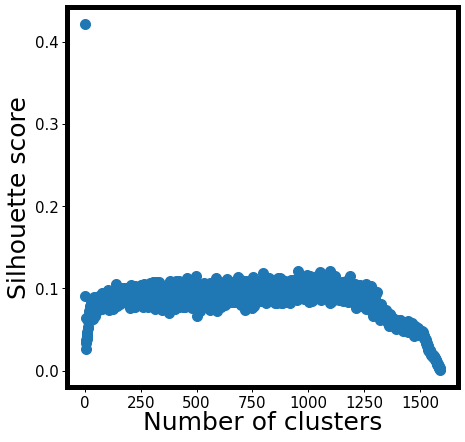

In [8]:
# Do kmeans clustering on the expected length sequences with more reads than read_threshold in R9
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    best_num_clusters = find_best_clustering(sequence_list1)

# Show clustering
cluster_dict1 = show_clusters(best_num_clusters, sequence_list1, Counts, 'R9')


<p style="font-size:25px;"> Do kmeans clustering on the set of sequences that encode 1 RNA
<p style="font-size:12px;"> First, set parameter values:
<p style="font-size:12px;"> promoter_tolerance = maximum edit distance to classify a substring as containing the T7 promoter
<p style="font-size:12px;"> one_or_two_RNAs = choose whether you want to assess the 1 or 2 RNA pool

In [9]:
promoter_tolerance = 2
one_or_two_RNAs = 1

In [10]:
def is_promoter_present(DNA1, tolerance):
    # Determine if T7 promoter sequence is present (and thus if this strand encodes an RNA). 
    # First, check if exact promoter sequence is present.
    # If not, check for a substring that has an edit distance with the promoter sequence less than tolerance
    T7_promoter = Seq('TAATACGACTCACTATAGG')
    if DNA1.find(T7_promoter) != -1:
        return(1)
    for i in range(len(DNA1) - len(T7_promoter)):
        substring = DNA1[i:i + len(T7_promoter)]
        edit_dist = nltk.edit_distance(substring, T7_promoter)
        if edit_dist <= tolerance:
            return(1)
    return(0)

def find_all_promoters(DNA1, tolerance):
    promoter_count = is_promoter_present(DNA1, tolerance)
    DNA_rev_comp = DNA1.reverse_complement()
    promoter_count += is_promoter_present(DNA_rev_comp, tolerance)
    return(promoter_count)

def identify_cluster(cluster_dict1I):
    promoter_count_list = []
    for s in cluster_dict1I[0:10]:
        promoter_count = find_all_promoters(Seq(s), promoter_tolerance)
        promoter_count_list.append(promoter_count)
    first_value = promoter_count_list[0]
    if all(element == first_value for element in promoter_count_list):
        return(first_value)

In [11]:
# Identify which cluster contains variants that encode the desired number of RNAs
for c in cluster_dict1:
    if identify_cluster(cluster_dict1[c]) == one_or_two_RNAs:
        chosen_cluster = cluster_dict1[c]

24% of all sequences have been analyzed
49% of all sequences have been analyzed
74% of all sequences have been analyzed
98% of all sequences have been analyzed
Number of clusters that maximizes silhoutte score = 72



C:\Users\zackc\AppData\Local\Temp\ipykernel_6784\3840567723.py:36: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  matrix = np.asarray([np.fromstring(s, dtype=np.uint8) for s in sequence_list1])


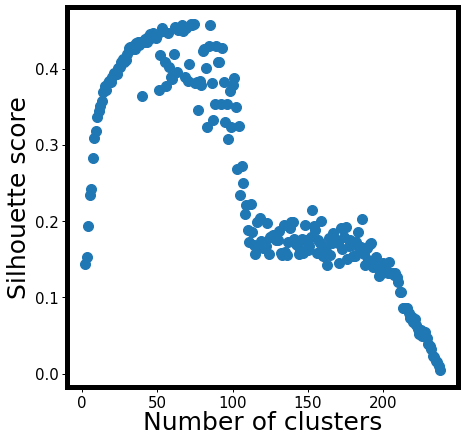

In [12]:
# Do kmeans clustering of the variants from the chosen cluster
# Cluster based on the entire variant sequence (excluding primer binding sites)
sequence_list = chosen_cluster

# Take the sequences from the smaller initial cluster, and do another round of k-means clustering
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    best_num_clusters = find_best_clustering(sequence_list)

# Show clustering
cluster_dict_whole = show_clusters(best_num_clusters, sequence_list, Counts, 'R9')

<p style="font-size:25px;"> Output information about each variant

In [13]:
def assign_order(list1, string1, ordering1):
    order = 0
    for tup in list1:
        if tup[0] in ordering1:
            ordering1[tup[0]][string1] = order
            order += 1
    return(ordering1)


In [14]:
# Rank the EXPECTED LENGTH sequences based on a few important metrics
# Metric 1 = enrichment from R8_expected_size to R9
# Metric 2 = enrichment from R8 to R9
# Metric 3 = R9 abundance

ordering = {}
for s in Counts:
    if len(s) == 108 and Counts[s]['R9'] > read_threshold:
        ordering[s] = {}
        
R8_expected_R9_enrichment = sorted(Counts.items(), key=lambda x: enrichment(x[1], 'R8_expected_size', 'R9'), reverse=True)
R8_R9_enrichment = sorted(Counts.items(), key=lambda x: enrichment(x[1], 'R8', 'R9'), reverse=True)
R9_abundance = sorted(Counts.items(), key=lambda x: x[1]['R9'], reverse=True)
checks = [time.time()]

ordering = assign_order(R8_expected_R9_enrichment, 'R8_expected_R9_enrichment', ordering)
ordering = assign_order(R8_R9_enrichment, 'R8_R9_enrichment', ordering)
ordering = assign_order(R9_abundance, 'R9_abundance', ordering)


In [15]:
# For convenience, create dictionaries with key = sequence, value = cluster
clusters1 = {}

def new_dict(dict_out, cluster_dictI):
    for c in cluster_dictI:
        seq_list = cluster_dictI[c]
        for s in seq_list:
            dict_out[s] = c
    return(dict_out)

clusters = new_dict(clusters1, cluster_dict_whole)



In [16]:
# Create data table of information for each variant

data = {'Sequence': [], 
        'R8_expected_R9_enrichment_rank': [],
        'R8_R9_enrichment_rank': [],
        'R9_abundance_rank': [],
        'Number of RNAs': [],
        'Length': [],
        'R0 counts': [],
        'R5 counts': [],
        'R6 counts': [],
        'R8 counts': [],
        'R8_expected_size counts': [],
        'R9 counts': [],
        'R9_expected_size counts': [],
        'R9_small_size counts': [],
        'Cluster': []}

tracker = 0
tracker_output = [x for x in range(0, len(sequence_list), int(0.25*len(sequence_list)))]
for seq in sequence_list:
    data['Sequence'].append('CAACTCACGGAACTCTGACG' + seq + 'GTTCGTGACTAGCCTGTCGA')
    data['R8_expected_R9_enrichment_rank'].append(ordering[seq]['R8_expected_R9_enrichment'])
    data['R8_R9_enrichment_rank'].append(ordering[seq]['R8_R9_enrichment'])
    data['R9_abundance_rank'].append(ordering[seq]['R9_abundance'])
    data['Number of RNAs'].append(len(find_all_RNAs(Seq(seq))))
    data['Length'].append(len(seq) + 40)
    data['R0 counts'].append(Counts[seq]['R0'])
    data['R5 counts'].append(Counts[seq]['R5'])
    data['R6 counts'].append(Counts[seq]['R6'])
    data['R8 counts'].append(Counts[seq]['R8'])
    data['R8_expected_size counts'].append(Counts[seq]['R8_expected_size'])
    data['R9 counts'].append(Counts[seq]['R9'])
    data['R9_expected_size counts'].append(Counts[seq]['R9_expected_size'])
    data['R9_small_size counts'].append(Counts[seq]['R9_small_size'])
    data['Cluster'].append(clusters[seq])
    if tracker in tracker_output:
        print(str(int(100*tracker/len(sequence_list1))) + '% of all sequences have been analyzed')
    tracker += 1

0% of all sequences have been analyzed
3% of all sequences have been analyzed
7% of all sequences have been analyzed
11% of all sequences have been analyzed
14% of all sequences have been analyzed


In [17]:
# Print table sorted by enrichment
df = pd.DataFrame(data)
df_sorted = df.sort_values('R8_R9_enrichment_rank')
df_sorted.head()
#df_sorted.to_csv('1RNA variants sorted by enrichment.csv', index=False)

,Sequence,R8_expected_R9_enrichment_rank,R8_R9_enrichment_rank,R9_abundance_rank,Number of RNAs,Length,R0 counts,R5 counts,R6 counts,R8 counts,R8_expected_size counts,R9 counts,R9_expected_size counts,R9_small_size counts,Cluster
50,CAACTCACGGAACTCTGACGACACTTATACAGAAGTCCTAACGAGT...,1,1,19,1,148,0,0,0,0,2,32,16,0,2
20,CAACTCACGGAACTCTGACGTACGTTGTAGTCTCCAGACACCGAGA...,47,7,8,1,148,0,1,0,7,28,115,141,0,4
1,CAACTCACGGAACTCTGACGAGCGCGAATTGATTTCATATTCAGAC...,3,8,0,1,148,0,1,5,31,37,504,601,0,42
43,CAACTCACGGAACTCTGACGGGCGTACTCAGGACACTTATATCTTG...,35,11,4,1,148,0,0,0,15,37,206,271,0,0
49,CAACTCACGGAACTCTGACGAGCGCGAATTGATTTCATATTCAGAC...,4,12,53,1,148,0,0,0,0,1,13,25,0,42
